In [1]:
import numpy as np
import pandas as pd
# from stratmanager import StrategyManager
# import sklearn.mixture as mix
import matplotlib.pyplot as plt

In [2]:
df = pd.read_json('data/ETH_USDT-5m.json')
df.columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume']
# convert timestamp to datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
# set timestamp as index
df.set_index('timestamp', inplace=True)

df.head()

,open,high,low,close,volume
timestamp,,,,,
2017-08-17 04:00:00,301.13,301.13,300.00,301.13,3.82951
2017-08-17 04:05:00,300.00,301.13,298.00,298.00,1.97216
2017-08-17 04:10:00,298.00,298.00,298.00,298.00,0.00000
2017-08-17 04:15:00,298.00,299.05,298.00,299.05,12.88486
2017-08-17 04:20:00,299.05,300.10,299.05,300.10,6.58304


In [3]:
def sharpe_ratio_call(return_series):
    N = 255 # Trading days in the year (change to 365 for crypto)
    rf = 0.01 # Half a percent risk free rare
    mean = return_series.mean() * N -rf
    sigma = return_series.std() * np.sqrt(N)
    sharpe = round(mean / sigma, 3)
    return sharpe

# Calculates returns for equity curve
def calculate_returns(df, is_benchmark):
    # Calculate multiplier
    if not is_benchmark:
        multiplier_1 = df["signal"]
        multiplier_2 = 1 if "psignal" not in df.columns else df["psignal"]
        log_rets = np.log(df["close"] / df["close"].shift(1)) * multiplier_1 * multiplier_2
    else:
        multiplier_1 = 1
        multiplier_2 = 1

        # Assume open price on following day to avoid lookahead bias for close calculation
        log_rets = np.log(df["open"].shift(-1) / df["close"].shift(1)) * multiplier_1 * multiplier_2

    # Calculate Sharpe Ratio
    sharpe_ratio = sharpe_ratio_call(log_rets)

    # Calculate Cumulative Returns
    c_log_rets = log_rets.cumsum()
    c_log_rets_exp = np.exp(c_log_rets) - 1

    # Return result and Sharpe ratio
    return c_log_rets_exp, sharpe_ratio


# Calculates general period returns and volatility
def structure_df(df):
    df["returns"] = df["close"].pct_change()
    df["range"] = df["high"] / df["low"] - 1
    df["benchmark_cummulative_returns"], sharpe = calculate_returns(df, True)
    df.dropna(inplace=True)
    return df

In [4]:
df.dropna(inplace=True)
df = structure_df(df)
df.head()

,open,high,low,close,volume,returns,range,benchmark_cummulative_returns
timestamp,,,,,,,,
2017-08-17 04:05:00,300.00,301.13,298.00,298.00,1.97216,-0.010394,0.010503,-0.010394
2017-08-17 04:10:00,298.00,298.00,298.00,298.00,0.00000,0.000000,0.000000,-0.010394
2017-08-17 04:15:00,298.00,299.05,298.00,299.05,12.88486,0.003523,0.003523,-0.006907
2017-08-17 04:20:00,299.05,300.10,299.05,300.10,6.58304,0.003511,0.003511,-0.005745
2017-08-17 04:25:00,299.40,300.80,299.39,299.39,11.97275,-0.002366,0.004710,-0.008097


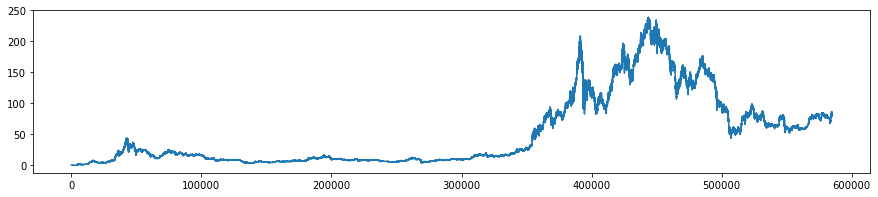

In [5]:
# Benchmark Returns Profile
fig = plt.figure(figsize = (15, 3))
plt.plot(df["benchmark_cummulative_returns"].values)
plt.show()

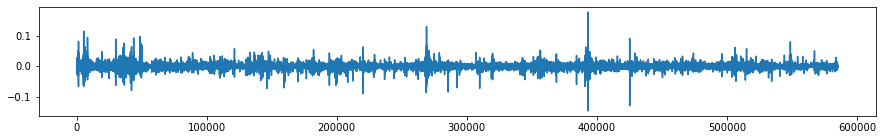

In [6]:
# Benchmark Returns Profile
fig = plt.figure(figsize = (15, 2))
plt.plot(df["returns"].values)
plt.show()

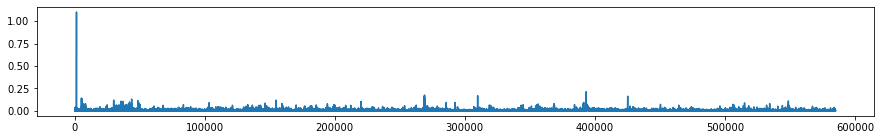

In [7]:
# Benchmark Range Profile
fig = plt.figure(figsize = (15, 2))
plt.plot(df["range"].values)
plt.show()

In [8]:
## Features

# Add RSI
from ta.momentum import RSIIndicator
df["rsi"] = RSIIndicator(close=df["close"], window=14).rsi() 
df["rsi_returns"] = df["rsi"] / df["rsi"].shift(1)

# Add Moving Average
df["ma_12"] = df["close"].rolling(window=12).mean()
df["ma_21"] = df["close"].rolling(window=21).mean()

# Day of Week
df["dow"] = df.index.dayofweek

# Rolling Cumulative Returns
df["roll_returns"] = df["returns"].rolling(window=30).sum()

# Rolling Cumulative Range
df["avg_range"] = df["range"].rolling(window=30).mean()

df[["open_change", "high_change", "low_change", "volume_change"]] = df[["open", "high", "low", "volume"]].pct_change()

In [9]:
# Add Time Intervals
t_steps = [1, 2]
t_features = ["returns", "range", "rsi_returns"]
for ts in t_steps:
    for tf in t_features:
        df[f"{tf}_T{ts}"] = df[tf].shift(ts)
        
        
print(df.columns)
df.head()

Index(['open', 'high', 'low', 'close', 'volume', 'returns', 'range',
       'benchmark_cummulative_returns', 'rsi', 'rsi_returns', 'ma_12', 'ma_21',
       'dow', 'roll_returns', 'avg_range', 'open_change', 'high_change',
       'low_change', 'volume_change', 'returns_T1', 'range_T1',
       'rsi_returns_T1', 'returns_T2', 'range_T2', 'rsi_returns_T2'],
      dtype='object')


,open,high,low,close,volume,returns,range,benchmark_cummulative_returns,rsi,rsi_returns,...,open_change,high_change,low_change,volume_change,returns_T1,range_T1,rsi_returns_T1,returns_T2,range_T2,rsi_returns_T2
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-08-17 05:00:00,301.61,303.28,300.00,303.10,377.67246,0.004940,0.010933,0.002619,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-17 06:00:00,302.40,304.44,301.90,302.68,303.86672,-0.001386,0.008413,0.001230,NaN,NaN,...,0.002619,0.003825,0.006333,-0.195423,0.004940,0.010933,NaN,NaN,NaN,NaN
2017-08-17 07:00:00,302.68,307.96,302.60,307.96,754.74510,0.017444,0.017713,0.018663,NaN,NaN,...,0.000926,0.011562,0.002319,1.483803,-0.001386,0.008413,NaN,0.004940,0.010933,NaN
2017-08-17 08:00:00,307.95,309.97,307.00,308.62,150.75029,0.002143,0.009674,0.020846,NaN,NaN,...,0.017411,0.006527,0.014541,-0.800263,0.017444,0.017713,NaN,-0.001386,0.008413,NaN
2017-08-17 09:00:00,308.62,312.00,308.62,310.00,469.27879,0.004472,0.010952,0.025410,NaN,NaN,...,0.002176,0.006549,0.005277,2.112954,0.002143,0.009674,NaN,0.017444,0.017713,NaN


In [10]:
# Check for NaN
df.dropna(inplace=True)
print(df.isnull().values.any())

# Check for Inf values
dfobj = df.isin([np.inf, -np.inf])
count = np.isinf(dfobj).values.sum()
print(count)

False
0


In [11]:
# Check for non-numerical objects
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48766 entries, 2017-08-18 10:00:00 to 2023-03-17 14:00:00
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   open                           48766 non-null  float64
 1   high                           48766 non-null  float64
 2   low                            48766 non-null  float64
 3   close                          48766 non-null  float64
 4   volume                         48766 non-null  float64
 5   returns                        48766 non-null  float64
 6   range                          48766 non-null  float64
 7   benchmark_cummulative_returns  48766 non-null  float64
 8   rsi                            48766 non-null  float64
 9   rsi_returns                    48766 non-null  float64
 10  ma_12                          48766 non-null  float64
 11  ma_21                          48766 non-null  float64
 12  dow        

In [12]:
df.to_csv('data/ETH_USDT-1h_processed.csv')